# Pytorch CNN | Brain Tumor MRI Detection **83% Accuracy**

#### **[Link to Dataset](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection)**

```
Basically, I'm new to Deep Learning, I've tried using CNNs before using Tensorflow on simple datasets such as MNIST but with Pytorch I learnt about all the operations in detail. 
If you come across this notebook, please let me know on what mistakes I made and what I could improve on, etc.
```

### Things I learnt with this:

- Torchvision transforms
- **Convolutional Neural Networks**
    - 2D Convolution operation
    - Max Pooling operation
    - Arranging layers in a CNN model
    - Calculating output sizes for each 2D operation
- Using GPU on Kaggle
    - still a long way to go, learnt about `gc.collect()` and `torch.cuda.empty_cache()` and garbage collection
    - I had CUDA out of memory issues, tried making minor changes to fully-connected layer in model and reduced the batch size of the dataset, worked for me.
    - *I'd appreciate guidance and feedback on GPU usage on Kaggle and Pytorch in general and what mistakes to avoid*

### *Thank you for checking out my notebook! Would appreciate feedback :)*
_____

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import gc

# **Preparing the dataset**

In [44]:
import os
dataset_path = '../input/brain-mri-images-for-brain-tumor-detection'

paths = []
labels = []

for label in ['yes','no']:
    for dirname, _, filenames in os.walk(os.path.join(dataset_path,label)):
        for filename in filenames:
            paths.append(os.path.join(dirname, filename))
            labels.append(1 if label is 'yes' else 0)

len(paths), len(labels)

(253, 253)

In [45]:
# image size details

sizes = []
for path in paths:
    im = Image.open(path)
    sizes.append(im.size)
    im.close()
    
print(max(sizes), min(sizes))

(1920, 1080) (150, 198)


In [46]:
# stratified split into train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(paths, 
                                                    labels, 
                                                    stratify=labels, 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=1357
                                                   )

print(len(X_train), len(X_test))

202 51


## Custom Dataset

In [47]:
class MRIDataset():
    def __init__(self, paths, labels, augmentations=None):
        self.paths = paths
        self.labels = labels
        
        if augmentations is None:
            self.augmentations = transforms.Compose([transforms.ToTensor()])
        else:
            self.augmentations = augmentations
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        
        label = self.labels[index]
        
        sample = Image.open(self.paths[index]).convert(mode="RGB")
        sample = self.augmentations(sample)
            
        return (sample,torch.tensor(label, dtype=torch.float))

## Augmentations

In this particular dataset, all the MRIs are straight, mostly grayscale, *different sizes*, mostly centered.

I've decided on the following:

- Resize to 224x224px
- RandomHorizontalFlip(0.2)
- RandomVerticalFlip(0.1)
- RandomAutoContrast(0.2)
- RandomAutoSharpness(0.3)

Both for training and testing datasets.

In [48]:
train_augmentations = transforms.Compose([transforms.Resize((224,224)),
                                          transforms.RandomHorizontalFlip(0.2),
                                          transforms.RandomVerticalFlip(0.1),
                                          transforms.RandomAutocontrast(0.2),
                                          transforms.RandomAdjustSharpness(0.3),
                                          transforms.ToTensor()
                                         ])

test_augmentations = transforms.Compose([transforms.Resize((224,224)),
                                          transforms.RandomHorizontalFlip(0.2),
                                          transforms.RandomVerticalFlip(0.1),
                                          transforms.RandomAutocontrast(0.2),
                                          transforms.RandomAdjustSharpness(0.3),
                                          transforms.ToTensor()
                                         ])

In [49]:
train_dataset = MRIDataset(X_train, y_train, augmentations=train_augmentations)
test_dataset = MRIDataset(X_test, y_test, augmentations=test_augmentations)

**NOTE**

- Pillow Images on transforms are in the shape (channels, height, width). To plot them, we need to reshape them to (height, width, channels). Hence usage of torch.permute(), 1: height, 2: width, 3: channels

torch.Size([3, 224, 224])
1.0


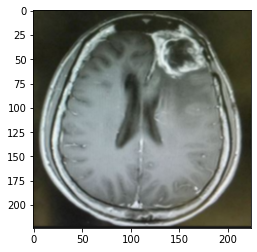

In [50]:
import matplotlib.pyplot as plt

random_sample, random_label = test_dataset[0]
print(random_sample.shape)
plt.imshow(random_sample.permute(1,2,0))
print(random_label.item())

# **Model**

## Model Config

In [51]:
class Config:
    learning_rate = 1e-3
    epochs = 10
    train_batch_size = 8
    test_batch_size = 8

## DataLoaders

In [52]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size = Config.train_batch_size,
                                               shuffle = True,
                                               num_workers = 2
                                              )

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size = Config.test_batch_size,
                                              shuffle = True,
                                              num_workers = 2
                                              )

len(train_dataloader), len(test_dataloader)

(26, 7)

# **CNN Model**

**Conv2d**

input: 
```
width1 * height1 * in_channels
kernel_size: f
num_filters: k
stride: s
padding: p
```

output:
```
width2 = (width1 - f + 2*p)/s + 1
height2 = (height1 - f + 2*p)/s + 1
out_channels = k
```
    
**MaxPool2d**

input:
```
width1 * height1 * in_channels
kernel_size: f
stride: s
```
output:
```
width2 = (width1 - f)/s + 1
height2 = (height1 - f)/s + 1
out_channels = in_channels
```


In [53]:
class Model(nn.Module):
    
    def __init__(self, in_features=3):
        super(Model, self).__init__()
        
    
        self.conv_block = nn.Sequential(nn.Conv2d(in_channels=in_features, 
                                                 out_channels=32, 
                                                 kernel_size=3, 
                                                 stride=1
                                                 ),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2,2),
                                       
                                       nn.Conv2d(in_channels=32, 
                                                 out_channels=64, 
                                                 kernel_size=3, 
                                                 stride=1
                                                ),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2,2)
                                      )
        
        self.linear_block = nn.Sequential(nn.Linear(64*54*54, 1024),
                                          nn.ReLU(),
                                          nn.Dropout(0.5),
                                          nn.Linear(1024,256),
                                          nn.ReLU(),
                                          nn.Dropout(0.3),
                                          nn.Linear(256,1)
                                         )
        
    
    def forward(self,x):
        x = self.conv_block(x)
        x = torch.flatten(x,1)
        x = self.linear_block(x)
        return x

In [54]:
model = Model()
print(model)

Model(
  (conv_block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=186624, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# **Training**

In [56]:
class Trainer:
    
    def __init__(self, model, dataloaders, Config):
        self.model = model
        self.train, self.test = dataloaders
        
        self.Config = Config
        
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.Config.learning_rate)
        self.loss_fn = nn.BCEWithLogitsLoss()
        
        
    def binary_accuracy(self, outputs, labels):
        return (torch.round(torch.sigmoid(outputs)) == labels).sum().item() / labels.shape[0]
        
        
    def train_one_epoch(self):
        
        running_loss = 0
        running_acc = 0
        
        for X,y in self.train:
            
            X = X.to(device, dtype = torch.float)
            y = y.reshape(y.shape[0],1)
            y = y.to(device, dtype = torch.float)
            
            self.optim.zero_grad()
            
            outputs = self.model(X)
            loss = self.loss_fn(outputs, y)
            
            loss.backward()
            self.optim.step()
            
            running_loss += loss.item()
            running_acc += self.binary_accuracy(outputs, y)
            
            del X
            del y
            gc.collect()
            torch.cuda.empty_cache()
            
        train_loss = running_loss / len(self.train)
        train_acc = running_acc / len(self.train)
        
        return train_loss, train_acc
            
    
    def fit(self):
        
        losses = []
        accuracies = []
        
        for epoch in range(self.Config.epochs):
            
            self.model.train()
            
            train_loss, train_acc = self.train_one_epoch()
            losses.append(train_loss)
            accuracies.append(train_acc)
            
            print(f"EPOCH {epoch+1}/{self.Config.epochs}")
            print(f"Training Loss: {train_loss} | Training Accuracy: {train_acc}\n\n")
            
    
    @torch.no_grad()
    def inference(self):
        
        self.model.eval()
    
        running_acc = 0
        
        for X,y in self.test:
            
            X = X.to(device, torch.float)
            y = y.reshape(y.shape[0],1)
            y = y.to(device, dtype = torch.float)
            outputs = self.model(X)
            running_acc += self.binary_accuracy(outputs, y)
            
            del X
            del y
            gc.collect()
            torch.cuda.empty_cache()
            
        accuracy = running_acc / len(self.test)
        
        return accuracy
    
            

In [57]:
trainer = Trainer(model, (train_dataloader, test_dataloader), Config)
trainer.fit()

EPOCH 1/10
Training Loss: 0.8138170735194132 | Training Accuracy: 0.6442307692307693


EPOCH 2/10
Training Loss: 0.518592503781502 | Training Accuracy: 0.7788461538461539


EPOCH 3/10
Training Loss: 0.42833526231921637 | Training Accuracy: 0.8269230769230769


EPOCH 4/10
Training Loss: 0.31684807716653896 | Training Accuracy: 0.8894230769230769


EPOCH 5/10
Training Loss: 0.3311334927924551 | Training Accuracy: 0.8798076923076923


EPOCH 6/10
Training Loss: 0.23119670976526463 | Training Accuracy: 0.9134615384615384


EPOCH 7/10
Training Loss: 0.18267361393484932 | Training Accuracy: 0.9326923076923077


EPOCH 8/10
Training Loss: 0.19823190563609108 | Training Accuracy: 0.9278846153846154


EPOCH 9/10
Training Loss: 0.13658485267884457 | Training Accuracy: 0.9471153846153846


EPOCH 10/10
Training Loss: 0.09950474364897953 | Training Accuracy: 0.9567307692307693




In [58]:
accuracy = trainer.inference()
accuracy*100

83.92857142857143

In [59]:
gc.collect()
torch.cuda.empty_cache()